## 펀다_상점매출예측
2020-04-14

### 문제
핀테크 기업인 ‘FUNDA(펀다)’는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.
 
이번 대회에서는 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다.

### Data
* store_id : 상점의 고유 아이디
* card_id : 사용한 카드의 고유 아이디
* card_company : 비식별화된 카드 회사
* transacted_date: 거래 날짜
* transacted_time : 거래 시간 (시:분)
* installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
* region : 상점의 지역
* type_of_business:상점의 업종
* amount : 거래액(단위는 원이 아닙니다)

**[참고자료]**<br>
1. 딥러닝과 통계모델을 이용한 T-커머스 매출예측 <br>
http://kiise.or.kr/e_journal/2017/8/JOK/pdf/07.pdf

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
color = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

In [3]:
# warning 무시
import warnings
warnings.filterwarnings(action='ignore')

### 한글폰트 깨짐 문제


In [53]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [9]:
train_df = pd.read_csv("./data/funda_train.csv", parse_dates=["transacted_date"])
train_df.shape

(6556613, 9)

In [10]:
# submission_df=pd.read_csv("./data/submission.csv")
# submission_df.shape

(1967, 2)

In [10]:
train_df

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   datetime64[ns]
 4   transacted_time   object        
 5   installment_term  int64         
 6   region            object        
 7   type_of_business  object        
 8   amount            float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 450.2+ MB


### 타겟변수 amount 살펴보기
* 양 끝에 outlier가 있는것으로 보임. outlier 제거 필요.

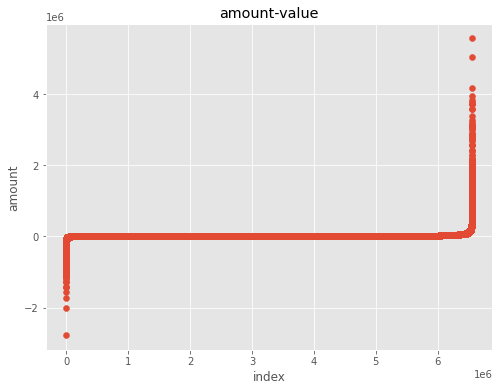

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df['amount'].values))
plt.xlabel('index',fontsize=12)
plt.ylabel('amount',fontsize=12)
plt.title('amount-value')
plt.show()

#### Outlier제거
* percentile 기준으로 99percentile 초과, 1percentile 미만은 Outlier로 취급

In [98]:
### 99percentile 이상과 1 percentile 이하 제거할 경우 각각 6만5천 row정도 제거됨.
ulimit = np.percentile(train_df['amount'].values, 99)
llimit = np.percentile(train_df['amount'].values, 1)
print(ulimit)
print(llimit)

108571.42857142855
-157.1428571428571


In [111]:
print(train_df.shape)
print(6556613-6425175)

(6556613, 14)
131438


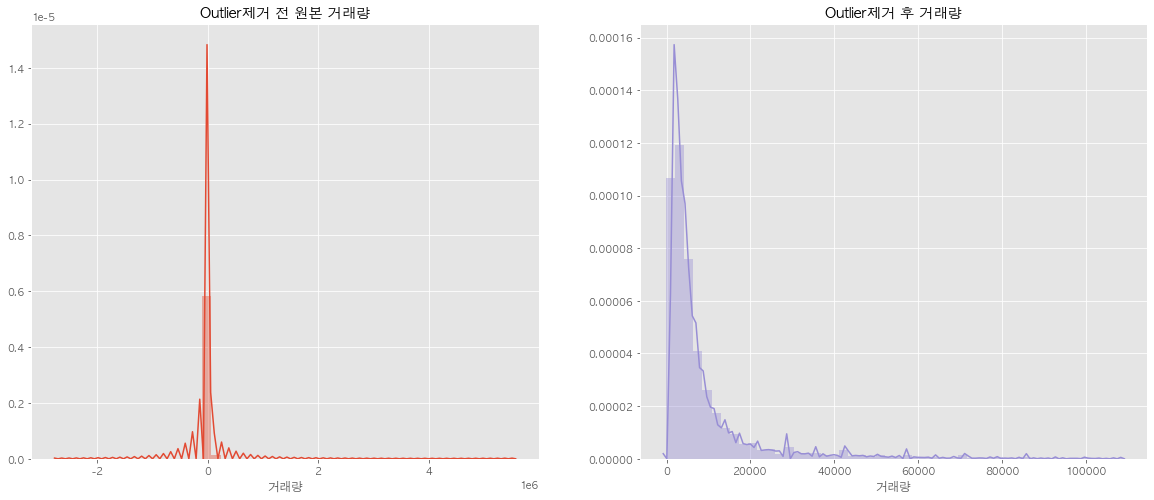

In [120]:
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,8)
sns.distplot(train_df['amount'],bins=50,ax=ax1)
sns.distplot(train_df['amount'][(train_df['amount']<ulimit) & (train_df['amount']>llimit)].values, bins=50,color=color[2],ax=ax2)
ax1.set(xlabel='거래량',title='Outlier제거 전 원본 거래량')
ax2.set(xlabel='거래량',title='Outlier제거 후 거래량')
plt.show()

### 결측치 확인

In [26]:
# 결측치 확인 
train_df.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

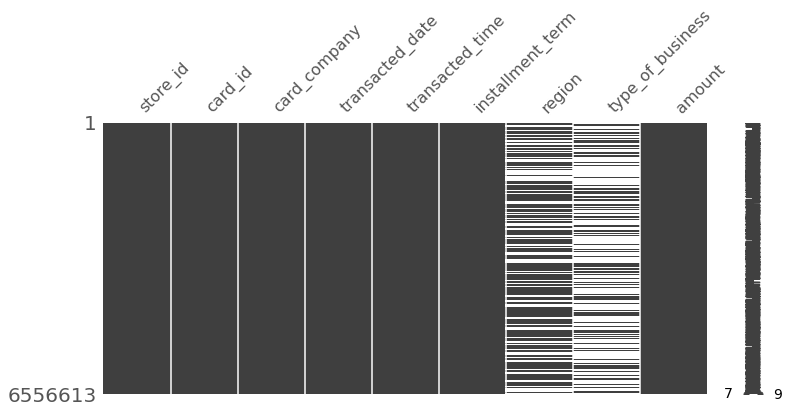

In [11]:
import missingno as msno

msno.matrix(train_df, figsize=(12,5))

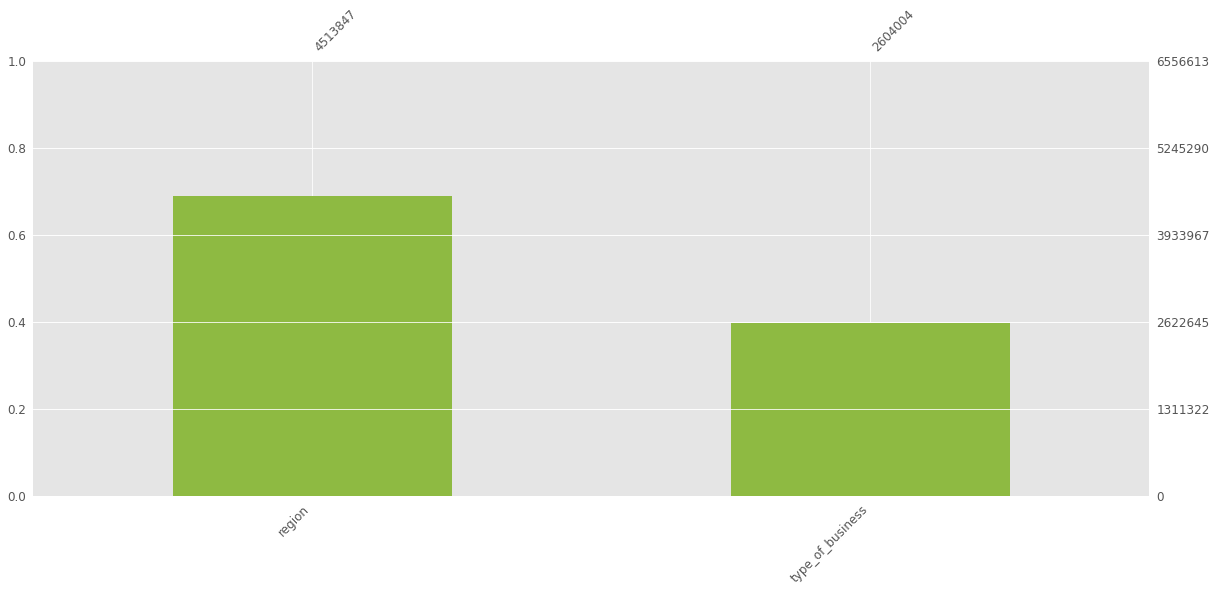

In [22]:
missingValueColumns=train_df.columns[train_df.isnull().any()].tolist()
msno.bar(train_df[missingValueColumns],figsize=(20,8),color=color[5],fontsize=12,labels=True)
plt.show()

### 날짜,시간 컬럼 분리

In [32]:
# transactied_time 컬럼은 시,분으로 이루어져있으므로 hour만 뽑아내기.
pd.to_datetime(train_df['transacted_time'],format='%H:%M').dt.hour

0          13
1          18
2          18
3          20
4          11
           ..
6556608    23
6556609    23
6556610    23
6556611    23
6556612    23
Name: transacted_time, Length: 6556613, dtype: int64

In [35]:
# 년도, 월, 일, 시간별 컬럼 분리
train_df['year']=train_df['transacted_date'].dt.year
train_df['month']=train_df['transacted_date'].dt.month
train_df['day']=train_df['transacted_date'].dt.day
train_df['hour']=pd.to_datetime(train_df['transacted_time'],format='%H:%M').dt.hour

In [37]:
train_df.shape

(6556613, 13)

In [38]:
train_df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,year,month,day,hour
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6,1,13
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6,1,18
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6,1,18
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6,1,20
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6,2,11


(python문법) <br>
* 리스트에는 map()함수를 적용하고, 데이터프레임에는 apply()함수 적용.
* 사용자정의 함수를 만들어서 apply로 적용해도되고, apply(lambda x: )함수를 함께 사용해도됨.

In [39]:
# 년도-월 컬럼 생성
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year,datetime.month)

In [45]:
train_df['transacted_date'].apply(lambda x: "{0}-{1}".format(x.year,x.month))

0          2016-6
1          2016-6
2          2016-6
3          2016-6
4          2016-6
            ...  
6556608    2019-2
6556609    2019-2
6556610    2019-2
6556611    2019-2
6556612    2019-2
Name: transacted_date, Length: 6556613, dtype: object

In [40]:
train_df['year_month']=train_df['transacted_date'].apply(concatenate_year_month)

In [47]:
train_df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,year,month,day,hour,year_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6,1,13,2016-6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6,1,18,2016-6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6,1,18,2016-6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6,1,20,2016-6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6,2,11,2016-6


### 년-월-일-시간 별 거래량

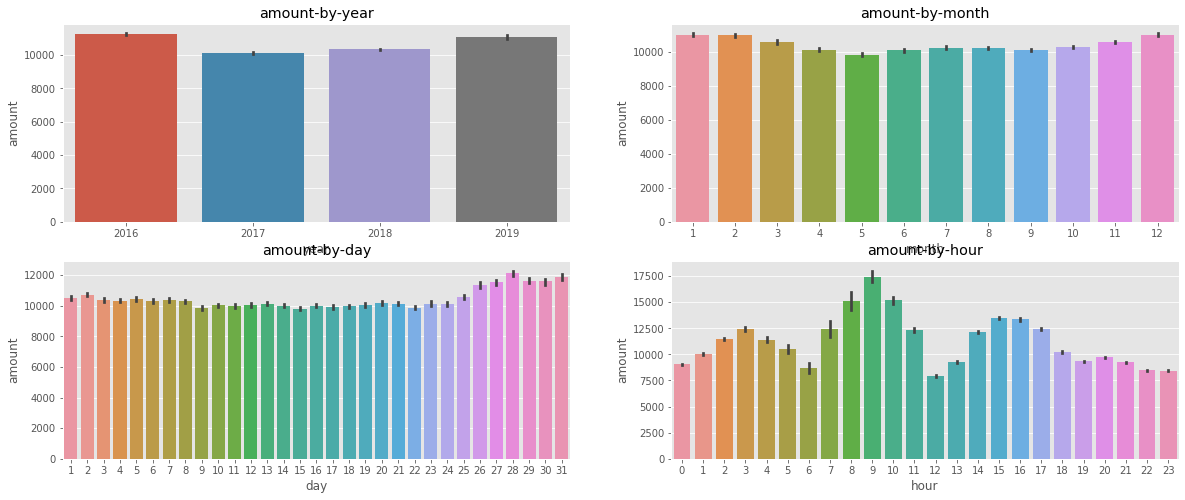

In [52]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=train_df,x="year",y="amount",ax=ax1)
sns.barplot(data=train_df,x="month",y="amount",ax=ax2)
sns.barplot(data=train_df,x="day",y="amount",ax=ax3)
sns.barplot(data=train_df,x="hour",y="amount",ax=ax4)

ax1.set(xlabel='year',ylabel='amount',title='amount-by-year')
ax2.set(xlabel='month',ylabel='amount',title='amount-by-month')
ax3.set(xlabel='day',ylabel='amount',title='amount-by-day')
ax4.set(xlabel='hour',ylabel='amount',title='amount-by-hour')
plt.show()

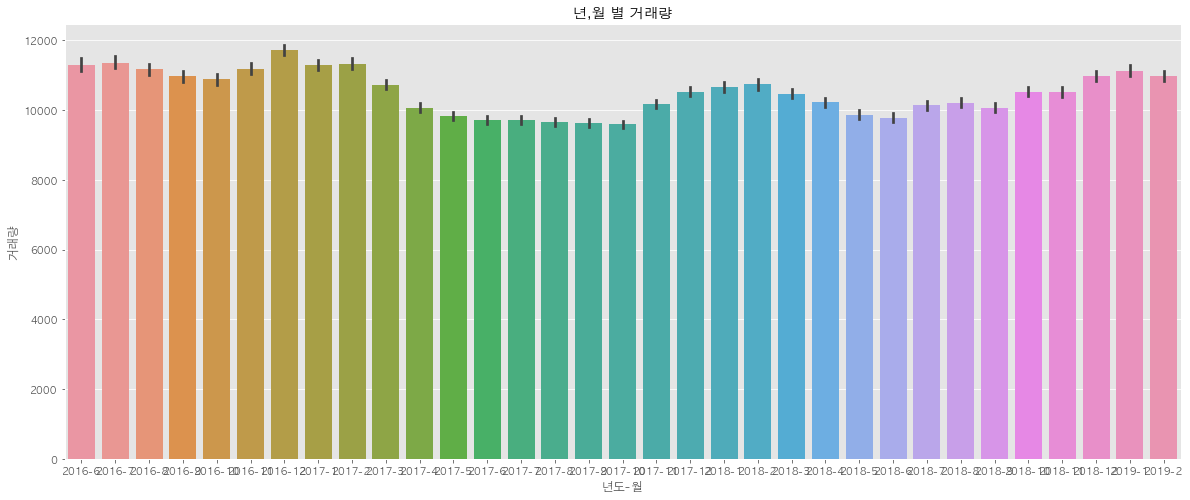

In [56]:
plt.figure(figsize=(20,8))
sns.barplot(data=train_df,x="year_month",y="amount")
plt.xlabel('년도-월',fontsize=12)
plt.ylabel('거래량',fontsize=12)
plt.title('년,월 별 거래량')
plt.show()

#### 매출이 높은 상점의 업종 TOP10 
* 의약품 도매업, 기타 산업용 농산물 도매업, 경영컨설팅업, 일반 병원 등이 높은 업종으로 나타남.

In [125]:
# 매출이 높은 업종 10개
train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=False)[:10].to_frame().reset_index()

,type_of_business,amount
0,의약품 도매업,354632.638674
1,기타 산업용 농산물 도매업,276625.139388
2,경영 컨설팅업,150819.538148
3,일반 병원,135287.727565
4,"주방용품 및 가정용 유리, 요업 제품 소매업",95901.011149
5,여행사업,83472.060730
6,상품 종합 도매업,73585.833643
7,의료용품 도매업,68497.066892
8,가구 소매업,67732.033782
9,귀금속 및 관련제품 제조업,63359.656169


#### 매출이 낮은 상점의 업종 10
* '의약품 도매업'은 매출이 가장 높았던 데 비해 '일반 의원'은 매출이 낮은 업종으로 분류
* '귀금속 및 관련제품 제조업' 은 매출이 높았던 데 비해, '시계 및 귀금속 소매업'은 매출이 낮아보임.

In [69]:
# 매출이 낮은 업종 10개
train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=True)[:10].to_frame()

,amount
type_of_business,
제과점업,913.737800
일반 의원,1406.982724
체인화 편의점,1593.218107
떡류 제조업,1825.979464
비알코올 음료점업,1970.210406
신선식품 및 단순 가공식품 도매업,2191.892393
당구장 운영업,2216.566487
그 외 기타 나무제품 제조업,2469.602340
중식 음식점업,2504.806029


#### 매출이 높은 상점의 지역
* 의외로 서울이 아닌 '경기 과천', '전남 완도군' 이 매출이 가장 높게나옴.
* 서울 강남구는 상위 5위에 속함

In [73]:
train_df.groupby(['region'])['amount'].mean().sort_values(ascending=False)[:10].to_frame()

,amount
region,
경기 과천시,58984.756834
전남 완도군,45119.572058
서울 광진구,44420.386452
경북 상주시,38071.436932
서울 강남구,33144.933447
경기 김포시,27419.659890
전남 담양군,26967.862115
부산 기장군,24468.758484
충북 옥천군,23071.366091


#### 매출이 낮은 상점의 지역
* 강원 철원군, 시종 고운서길이 매출이 낮은 상점 지역으로 나타났고, 서울 양천구는 서울임에도 불구하고 매출이 낮은 상점의 지역에 속함.

In [74]:
train_df.groupby(['region'])['amount'].mean().sort_values(ascending=True)[:10].to_frame()

,amount
region,
강원 철원군,1863.486008
세종 고운서길,2751.297153
경남 남해군,3051.031587
충남 예산군,3069.894499
세종 도움3로,3410.774512
충남 금산군,3592.849345
전북 김제시,3667.301628
경북 울진군,3806.350728
서울 양천구,4036.949217


#### 매출이 높은 업종별로 년도-월 별 매출흐름 확인

In [218]:
high_amount_business=train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=False)[:10].to_frame().reset_index()['type_of_business'].tolist()
high_amount_business

['의약품 도매업',
 '기타 산업용 농산물 도매업',
 '경영 컨설팅업',
 '일반 병원',
 '주방용품 및 가정용 유리, 요업 제품 소매업',
 '여행사업',
 '상품 종합 도매업',
 '의료용품 도매업',
 '가구 소매업',
 '귀금속 및 관련제품 제조업']

In [242]:
high_amount_business[1]    

'기타 산업용 농산물 도매업'

In [234]:
range(len(high_amount_business)-1)

range(0, 9)

In [283]:
train_df[['type_of_business','amount']][train_df['type_of_business']==high_amount_business[i]]

,type_of_business,amount
1482712,의약품 도매업,1.142857e+06
1482713,의약품 도매업,1.428571e+05
1482714,의약품 도매업,5.714286e+04
1482715,의약품 도매업,1.551343e+05
1482716,의약품 도매업,2.857143e+05
...,...,...
1487130,의약품 도매업,1.428571e+04
1487131,의약품 도매업,8.571429e+05
1487132,의약품 도매업,9.835714e+05
1487133,의약품 도매업,1.857143e+05


In [293]:
result=[]
for i in range(len(high_amount_business)-1):
    value=train_df[['type_of_business','year_month','amount']][train_df['type_of_business']==high_amount_business[i]]
    result.append(value)

### 문제
핀테크 기업인 ‘FUNDA(펀다)’는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.
 
이번 대회에서는 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다.

### Data
* store_id : 상점의 고유 아이디
* card_id : 사용한 카드의 고유 아이디
* card_company : 비식별화된 카드 회사
* transacted_date: 거래 날짜
* transacted_time : 거래 시간 (시:분)
* installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
* region : 상점의 지역
* type_of_business:상점의 업종
* amount : 거래액(단위는 원이 아닙니다)

**[참고자료]**<br>
1. 딥러닝과 통계모델을 이용한 T-커머스 매출예측 <br>
http://kiise.or.kr/e_journal/2017/8/JOK/pdf/07.pdf

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
color = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

In [3]:
# warning 무시
import warnings
warnings.filterwarnings(action='ignore')

### 한글폰트 깨짐 문제


In [53]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [9]:
train_df = pd.read_csv("./data/funda_train.csv", parse_dates=["transacted_date"])
train_df.shape

(6556613, 9)

In [10]:
# submission_df=pd.read_csv("./data/submission.csv")
# submission_df.shape

(1967, 2)

In [10]:
train_df

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   datetime64[ns]
 4   transacted_time   object        
 5   installment_term  int64         
 6   region            object        
 7   type_of_business  object        
 8   amount            float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 450.2+ MB


### 타겟변수 amount 살펴보기
* 양 끝에 outlier가 있는것으로 보임. outlier 제거 필요.

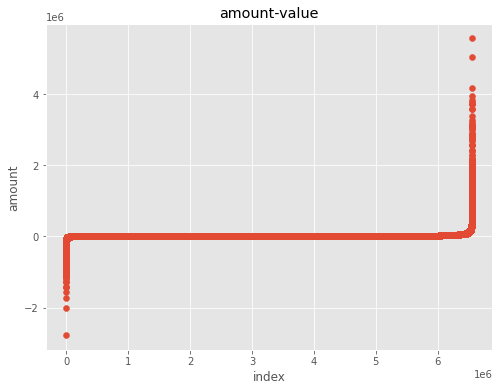

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df['amount'].values))
plt.xlabel('index',fontsize=12)
plt.ylabel('amount',fontsize=12)
plt.title('amount-value')
plt.show()

#### Outlier제거
* percentile 기준으로 99percentile 초과, 1percentile 미만은 Outlier로 취급

In [98]:
### 99percentile 이상과 1 percentile 이하 제거할 경우 각각 6만5천 row정도 제거됨.
ulimit = np.percentile(train_df['amount'].values, 99)
llimit = np.percentile(train_df['amount'].values, 1)
print(ulimit)
print(llimit)

108571.42857142855
-157.1428571428571


In [111]:
print(train_df.shape)
print(6556613-6425175)

(6556613, 14)
131438


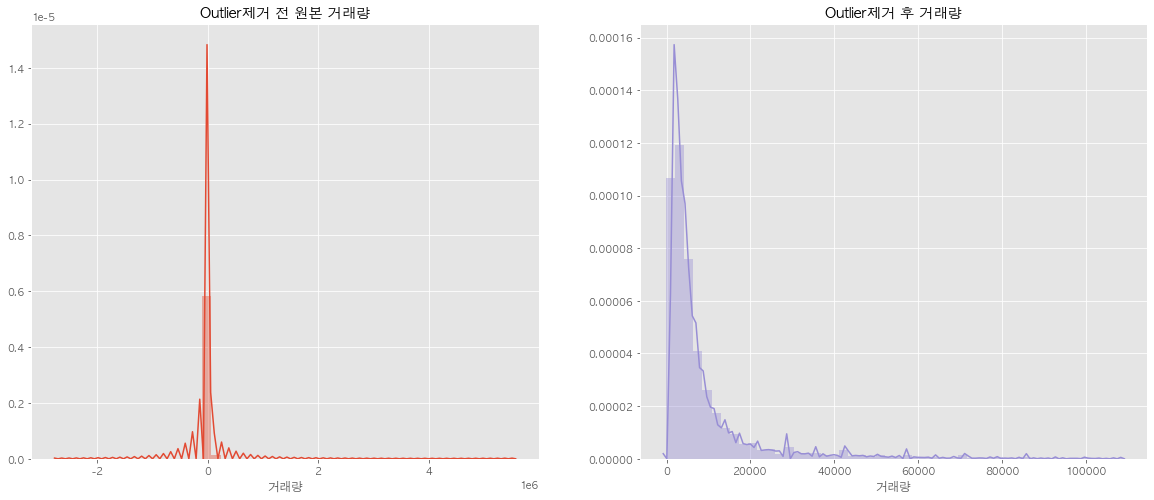

In [120]:
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,8)
sns.distplot(train_df['amount'],bins=50,ax=ax1)
sns.distplot(train_df['amount'][(train_df['amount']<ulimit) & (train_df['amount']>llimit)].values, bins=50,color=color[2],ax=ax2)
ax1.set(xlabel='거래량',title='Outlier제거 전 원본 거래량')
ax2.set(xlabel='거래량',title='Outlier제거 후 거래량')
plt.show()

### 결측치 확인

In [26]:
# 결측치 확인 
train_df.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

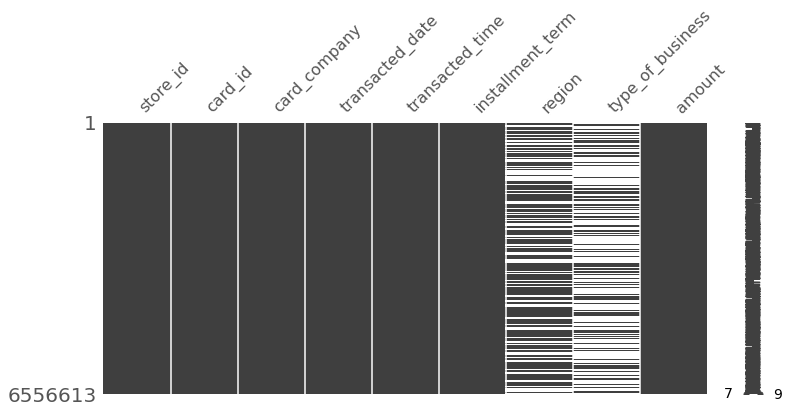

In [11]:
import missingno as msno

msno.matrix(train_df, figsize=(12,5))

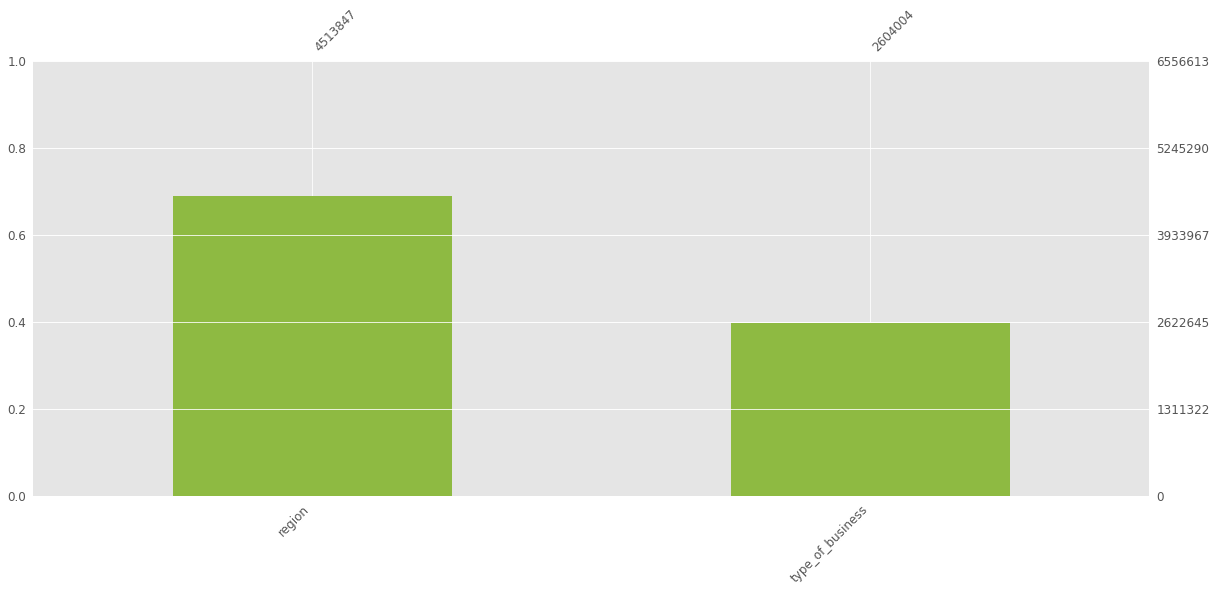

In [22]:
missingValueColumns=train_df.columns[train_df.isnull().any()].tolist()
msno.bar(train_df[missingValueColumns],figsize=(20,8),color=color[5],fontsize=12,labels=True)
plt.show()

### 날짜,시간 컬럼 분리

In [32]:
# transactied_time 컬럼은 시,분으로 이루어져있으므로 hour만 뽑아내기.
pd.to_datetime(train_df['transacted_time'],format='%H:%M').dt.hour

0          13
1          18
2          18
3          20
4          11
           ..
6556608    23
6556609    23
6556610    23
6556611    23
6556612    23
Name: transacted_time, Length: 6556613, dtype: int64

In [35]:
# 년도, 월, 일, 시간별 컬럼 분리
train_df['year']=train_df['transacted_date'].dt.year
train_df['month']=train_df['transacted_date'].dt.month
train_df['day']=train_df['transacted_date'].dt.day
train_df['hour']=pd.to_datetime(train_df['transacted_time'],format='%H:%M').dt.hour

In [37]:
train_df.shape

(6556613, 13)

In [38]:
train_df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,year,month,day,hour
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6,1,13
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6,1,18
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6,1,18
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6,1,20
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6,2,11


(python문법) <br>
* 리스트에는 map()함수를 적용하고, 데이터프레임에는 apply()함수 적용.
* 사용자정의 함수를 만들어서 apply로 적용해도되고, apply(lambda x: )함수를 함께 사용해도됨.

In [39]:
# 년도-월 컬럼 생성
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year,datetime.month)

In [45]:
train_df['transacted_date'].apply(lambda x: "{0}-{1}".format(x.year,x.month))

0          2016-6
1          2016-6
2          2016-6
3          2016-6
4          2016-6
            ...  
6556608    2019-2
6556609    2019-2
6556610    2019-2
6556611    2019-2
6556612    2019-2
Name: transacted_date, Length: 6556613, dtype: object

In [40]:
train_df['year_month']=train_df['transacted_date'].apply(concatenate_year_month)

In [47]:
train_df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,year,month,day,hour,year_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6,1,13,2016-6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6,1,18,2016-6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6,1,18,2016-6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6,1,20,2016-6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6,2,11,2016-6


### 년-월-일-시간 별 거래량

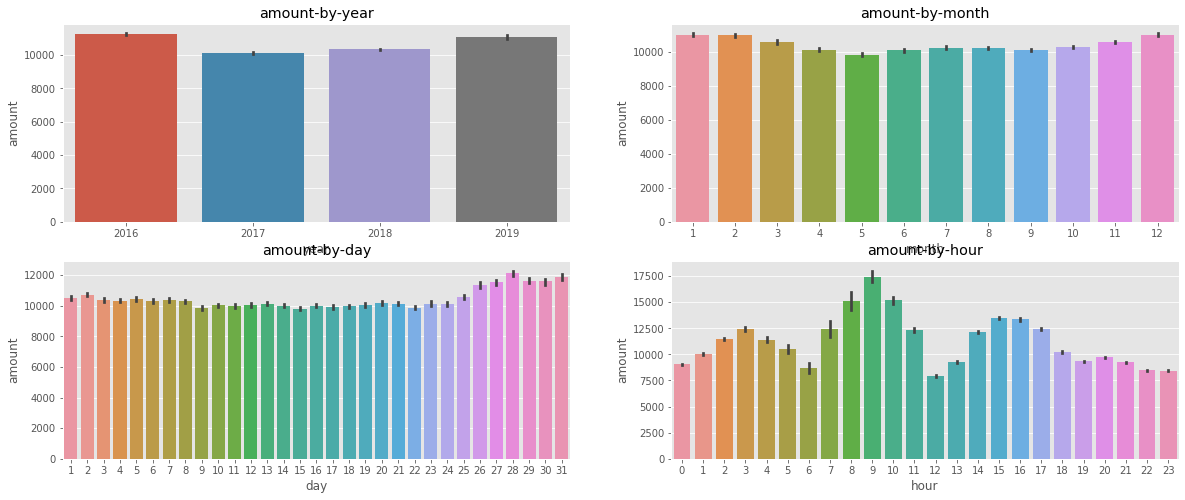

In [52]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=train_df,x="year",y="amount",ax=ax1)
sns.barplot(data=train_df,x="month",y="amount",ax=ax2)
sns.barplot(data=train_df,x="day",y="amount",ax=ax3)
sns.barplot(data=train_df,x="hour",y="amount",ax=ax4)

ax1.set(xlabel='year',ylabel='amount',title='amount-by-year')
ax2.set(xlabel='month',ylabel='amount',title='amount-by-month')
ax3.set(xlabel='day',ylabel='amount',title='amount-by-day')
ax4.set(xlabel='hour',ylabel='amount',title='amount-by-hour')
plt.show()

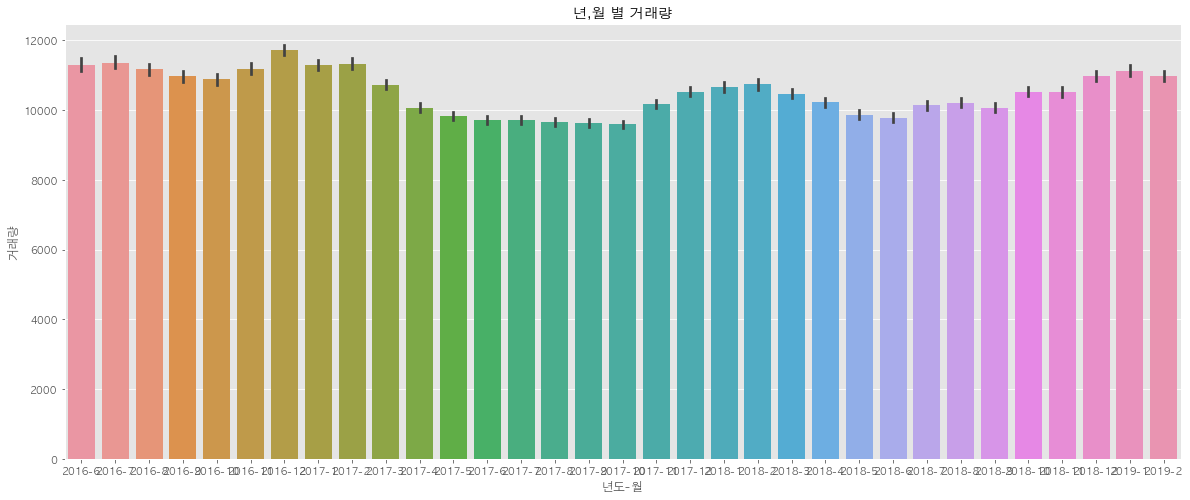

In [56]:
plt.figure(figsize=(20,8))
sns.barplot(data=train_df,x="year_month",y="amount")
plt.xlabel('년도-월',fontsize=12)
plt.ylabel('거래량',fontsize=12)
plt.title('년,월 별 거래량')
plt.show()

#### 매출이 높은 상점의 업종 TOP10 
* 의약품 도매업, 기타 산업용 농산물 도매업, 경영컨설팅업, 일반 병원 등이 높은 업종으로 나타남.

In [125]:
# 매출이 높은 업종 10개
train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=False)[:10].to_frame().reset_index()

,type_of_business,amount
0,의약품 도매업,354632.638674
1,기타 산업용 농산물 도매업,276625.139388
2,경영 컨설팅업,150819.538148
3,일반 병원,135287.727565
4,"주방용품 및 가정용 유리, 요업 제품 소매업",95901.011149
5,여행사업,83472.060730
6,상품 종합 도매업,73585.833643
7,의료용품 도매업,68497.066892
8,가구 소매업,67732.033782
9,귀금속 및 관련제품 제조업,63359.656169


#### 매출이 낮은 상점의 업종 10
* '의약품 도매업'은 매출이 가장 높았던 데 비해 '일반 의원'은 매출이 낮은 업종으로 분류
* '귀금속 및 관련제품 제조업' 은 매출이 높았던 데 비해, '시계 및 귀금속 소매업'은 매출이 낮아보임.

In [69]:
# 매출이 낮은 업종 10개
train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=True)[:10].to_frame()

,amount
type_of_business,
제과점업,913.737800
일반 의원,1406.982724
체인화 편의점,1593.218107
떡류 제조업,1825.979464
비알코올 음료점업,1970.210406
신선식품 및 단순 가공식품 도매업,2191.892393
당구장 운영업,2216.566487
그 외 기타 나무제품 제조업,2469.602340
중식 음식점업,2504.806029


#### 매출이 높은 상점의 지역
* 의외로 서울이 아닌 '경기 과천', '전남 완도군' 이 매출이 가장 높게나옴.
* 서울 강남구는 상위 5위에 속함

In [73]:
train_df.groupby(['region'])['amount'].mean().sort_values(ascending=False)[:10].to_frame()

,amount
region,
경기 과천시,58984.756834
전남 완도군,45119.572058
서울 광진구,44420.386452
경북 상주시,38071.436932
서울 강남구,33144.933447
경기 김포시,27419.659890
전남 담양군,26967.862115
부산 기장군,24468.758484
충북 옥천군,23071.366091


#### 매출이 낮은 상점의 지역
* 강원 철원군, 시종 고운서길이 매출이 낮은 상점 지역으로 나타났고, 서울 양천구는 서울임에도 불구하고 매출이 낮은 상점의 지역에 속함.

In [74]:
train_df.groupby(['region'])['amount'].mean().sort_values(ascending=True)[:10].to_frame()

,amount
region,
강원 철원군,1863.486008
세종 고운서길,2751.297153
경남 남해군,3051.031587
충남 예산군,3069.894499
세종 도움3로,3410.774512
충남 금산군,3592.849345
전북 김제시,3667.301628
경북 울진군,3806.350728
서울 양천구,4036.949217


#### 매출이 높은 업종별로 년도-월 별 매출흐름 확인

In [218]:
high_amount_business=train_df.groupby(['type_of_business'])['amount'].mean().sort_values(ascending=False)[:10].to_frame().reset_index()['type_of_business'].tolist()
high_amount_business

['의약품 도매업',
 '기타 산업용 농산물 도매업',
 '경영 컨설팅업',
 '일반 병원',
 '주방용품 및 가정용 유리, 요업 제품 소매업',
 '여행사업',
 '상품 종합 도매업',
 '의료용품 도매업',
 '가구 소매업',
 '귀금속 및 관련제품 제조업']

In [242]:
high_amount_business[1]    

'기타 산업용 농산물 도매업'

In [234]:
range(len(high_amount_business)-1)

range(0, 9)

In [283]:
train_df[['type_of_business','amount']][train_df['type_of_business']==high_amount_business[i]]

,type_of_business,amount
1482712,의약품 도매업,1.142857e+06
1482713,의약품 도매업,1.428571e+05
1482714,의약품 도매업,5.714286e+04
1482715,의약품 도매업,1.551343e+05
1482716,의약품 도매업,2.857143e+05
...,...,...
1487130,의약품 도매업,1.428571e+04
1487131,의약품 도매업,8.571429e+05
1487132,의약품 도매업,9.835714e+05
1487133,의약품 도매업,1.857143e+05


In [293]:
result=[]
for i in range(len(high_amount_business)-1):
    value=train_df[['type_of_business','year_month','amount']][train_df['type_of_business']==high_amount_business[i]]
    result.append(value)